In [1]:
from pathlib import Path
from tqdm import trange
from tqdm.contrib.logging import logging_redirect_tqdm
import logging
from datetime import datetime
from torchmetrics import MeanSquaredError

import matplotlib.pyplot as plt
import numpy as np
from AGG.utils import Time2Vec
import torch
import torch.nn as nn

import matplotlib
%matplotlib inline

In [2]:
from torch.utils.data import Dataset, DataLoader
from Datasets.data_tools import random_index

class SinusoidData(object):
    def __init__(self, fs=1000, f=10, t_end=5):
        t = np.arange(0, t_end, 1 / fs)
        x = np.sin(2 * np.pi * f * t)
        self.fs = fs
        self.f = f
        self.x = x
        self.t = t
        t = np.arange(0, t_end, 1 / fs)
        x = np.sin(2 * np.pi * f * t)
        self.x = x
        self.t = t
        removed, remainder = random_index(x.shape[0], 0.99)
        self.training_samples = x[remainder]
        self.training_samples_t = t[remainder]
        _, target_index = random_index(removed.shape[0], 0.99)
        self.target_samples = x[removed[target_index]]
        self.target_samples_t = t[removed[target_index]]
    

class SinusoidDataset(Dataset):    
    def __init__(self, sinusoid: SinusoidData):
        self.sinusoid = sinusoid
        self.x = sinusoid.x
        self.t = sinusoid.t
        self.node = torch.tensor(sinusoid.training_samples).float()
        self.node_t = torch.tensor(sinusoid.training_samples_t).float()/sinusoid.t.max()
        self.target = torch.tensor(sinusoid.target_samples).float()
        self.target_t = torch.tensor(sinusoid.target_samples_t).float()/sinusoid.t.max()
        self.data = []
        for j in range(self.target.shape[0]):
            self.data.append({
                'node': self.node,
                'node_t': self.node_t,
                'target': self.target[j],
                'target_t': self.target_t[j]
            })
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
sinusoid_data = SinusoidData(f=1, t_end=10)
sinusoid_dataset = SinusoidDataset(sinusoid_data)

In [25]:
experiment = datetime.now().strftime("%d-%m_%H:%M:%S")
print(f'Log for {experiment=}')
dir_path = Path(f'./logs/{experiment}')
dir_path.mkdir(parents=True, exist_ok=True)

Log for experiment='11-01_10:41:42'


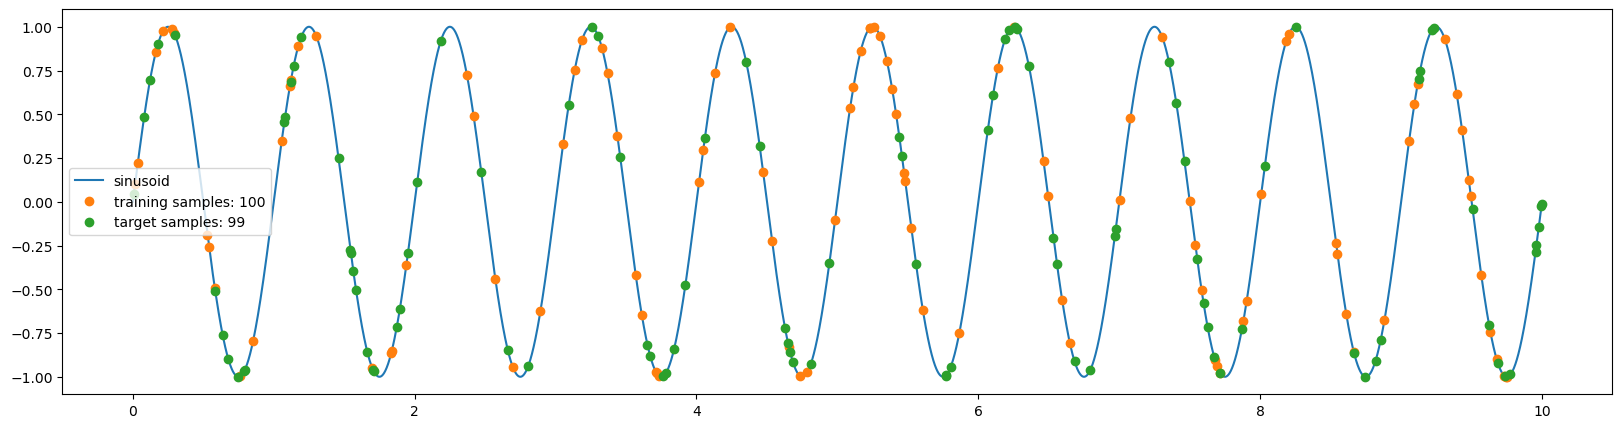

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(sinusoid_data.t, sinusoid_data.x, label='sinusoid')
plt.plot(sinusoid_data.training_samples_t, sinusoid_data.training_samples, 'o', label=f'training samples: {sinusoid_data.training_samples.shape[0]}')
plt.plot(sinusoid_data.target_samples_t, sinusoid_data.target_samples, 'o', label=f'target samples: {sinusoid_data.target_samples.shape[0]}')
plt.legend()
plt.savefig(dir_path / 'data_samples.png')
plt.show()

In [6]:
class GraphAttentionGenerator(nn.Module):
    def __init__(
            self, 
            query_dim: int, 
            key_dim: int, 
            hidden_dim: int, 
            dropout: float = 0.1, 
            negative_slope: float = 0.2
    ):   
        super(GraphAttentionGenerator, self).__init__()
        self.query_dim = query_dim
        self.key_dim = key_dim
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.linear_query = nn.Linear(query_dim, hidden_dim, bias=False)
        self.node_projection = nn.Linear(key_dim, hidden_dim, bias=False)
        self.attention = nn.Linear(hidden_dim, 1, bias=False)
        self.leaky_relu = nn.LeakyReLU(negative_slope=negative_slope)
        self.non_linearity = nn.ELU()
        
    def forward(self, query, key, value):
        # query: [batch_size, query_dim]
        # key: [batch_size, num_nodes, key_dim]
        # value: [batch_size, num_nodes, value_dim]
        batch_size, num_nodes, _ = key.shape
        query = query.unsqueeze(1).repeat(1, num_nodes, 1)
        # query: [batch_size, num_nodes, query_dim]
        h_query = self.linear_query(query)
        # h_query: [batch_size, num_nodes, hidden_dim]
        h_key = self.node_projection(key)
        # h_key: [batch_size, num_nodes, hidden_dim]
        h = h_query + h_key
        # h: [batch_size, num_nodes, hidden_dim]
        e = self.leaky_relu(h)
        e = self.attention(e)
        # e: [batch_size, num_nodes, 1]
        e = e.squeeze(-1)
        # e: [batch_size, num_nodes]
        e = self.dropout(e)
        e = torch.softmax(e, dim=-1)
        # e: [batch_size, num_nodes]
        scored_nodes = h_key * e.unsqueeze(-1)
        # scored_value: [batch_size, num_nodes, out_dim]
        scored_nodes = torch.sum(scored_nodes, dim=1)
        # scored_value: [batch_size, out_dim]
        h_prime = self.non_linearity(scored_nodes)
        return h_prime, e
        

In [7]:
class GraphSelfAttentionLayer(nn.Module):
    def __init__(
            self, 
            node_dim: int, 
            hidden_dim: int, 
            num_heads: int = 1,
            dropout: float = 0.6,
            negative_slope: float = 0.2,
            share_weights: bool = False
    ):   
        super(GraphSelfAttentionLayer, self).__init__()
        self.node_dim = node_dim
        self.hidden_dim = hidden_dim
        self.share_weights = share_weights
        self.dropout = nn.Dropout(dropout)
        self.linear_l = nn.Linear(node_dim, hidden_dim, bias=False)
        if share_weights:
            self.linear_r = self.linear_l
        else:
            self.linear_r = nn.Linear(node_dim, hidden_dim, bias=False)
        self.attention = nn.Linear(hidden_dim, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=negative_slope)
        self.non_linearity = nn.ELU()
        
    def forward(self, nodes):
        # nodes: [batch_size, num_nodes, node_dim]
        batch_size, num_nodes, _ = nodes.shape
        g_left = self.linear_l(nodes)
        # g_left: [batch_size, num_nodes, hidden_dim]
        g_right = self.linear_r(nodes)
        # g_right: [batch_size, num_nodes, hidden_dim]
        g_l_repeat = g_left.repeat(1, num_nodes, 1)
        # g_l_repeat: [batch_size, num_nodes*num_nodes, hidden_dim]
        g_r_repeat_interleave = g_right.repeat_interleave(num_nodes, dim=1)
        # g_r_repeat_interleave: [batch_size, num_nodes*num_nodes, hidden_dim]
        g = g_l_repeat + g_r_repeat_interleave
        # g: [batch_size, num_nodes*num_nodes, hidden_dim]
        g.view(batch_size, num_nodes, num_nodes, self.hidden_dim)
        # g: [batch_size, num_nodes, num_nodes, hidden_dim]
        e = self.leaky_relu(g)
        e = self.attention(e)
        # e: [batch_size, num_nodes, num_nodes, 1]
        e = e.squeeze(-1)
        # e: [batch_size, num_nodes, num_nodes]
        a = self.dropout(e)
        a = torch.softmax(a, dim=-1)
        # a: [batch_size, num_nodes, num_nodes]
        attention_result = torch.einsum('bij,bjf->bif', a, g_right)
        # attention_result: [batch_size, num_nodes, hidden_dim]
        attention_result = self.non_linearity(attention_result)
        return attention_result
        

In [8]:
class AGG(nn.Module):
    def __init__(
            self, 
            time_embed_dim: int, 
            feature_dim: int, 
            hidden_dim: int, 
            out_dim: int, 
            dropout: float = 0.1, 
            negative_slope: float = 0.2,
            include_linear: bool = True
    ):  
        super(AGG, self).__init__()
        self.time2vec = Time2Vec(time_embed_dim, include_linear=include_linear)
        self.key_dim = feature_dim + time_embed_dim
        self.value_dim = feature_dim + time_embed_dim
        
        self.graph_attention_generator = GraphAttentionGenerator(
            query_dim=time_embed_dim, 
            key_dim=self.key_dim, 
            hidden_dim=hidden_dim,
            dropout=dropout, 
            negative_slope=negative_slope
        )
        self.prediction = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, key_value, key_time, query_time, device: str = 'cpu'):
        key_value = key_value.unsqueeze(-1).to(device)
        key_time = key_time.unsqueeze(-1).to(device)
        query_time = query_time.unsqueeze(-1).to(device)
        
        # Time embedding for query and key
        query = self.time2vec(query_time)
        tau = self.time2vec(key_time)
        
        # Concatenate node_features and time embeddings
        key = torch.cat([key_value, tau], dim=-1)
        value = torch.cat([key_value, tau], dim=-1)
        
        # Generate conditional node
        h_prime, graph_attention = self.graph_attention_generator(query, key, value)
        y = self.prediction(h_prime)
        return y, graph_attention

In [9]:
model = AGG(
    time_embed_dim=4, 
    feature_dim=1, 
    hidden_dim=32, 
    out_dim=1, 
    dropout=0.1, 
    negative_slope=0.2,
    include_linear=True
)

sinusoid_dataloader = DataLoader(sinusoid_dataset, batch_size=10, shuffle=True, drop_last=False)
LOG = logging.getLogger(__name__)

logging.basicConfig(level=logging.INFO)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

print(f"Number of training samples: {len(sinusoid_dataset)}")
print(f"Model summary: {model}")
model = model.to(device)

Using device cuda:0
Number of training samples: 99
Model summary: AGG(
  (time2vec): Time2Vec(
    (scale): FrequencyScale(
      (unscaled_bias): Parameter(in_features=4)
      (linear): Linear(in_features=1, out_features=4, bias=False)
    )
  )
  (graph_attention_generator): GraphAttentionGenerator(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear_query): Linear(in_features=4, out_features=32, bias=False)
    (node_projection): Linear(in_features=5, out_features=32, bias=False)
    (attention): Linear(in_features=32, out_features=1, bias=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (non_linearity): ELU(alpha=1.0)
  )
  (prediction): Linear(in_features=32, out_features=1, bias=True)
)


In [27]:
model = model.to(device)
mse_loss = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.005)
train_RMSE = MeanSquaredError(squared=False).to(device)
val_RMSE = MeanSquaredError(squared=False).to(device)
epochs = 10000
total_train = np.inf
total_val = np.inf
lowest_loss = np.inf

train_loss_plot = []
val_loss_plot = []
val_RMSE_plot = []
train_RMSE_plot = []
t2v_weights = []
t2v_bias = []

with logging_redirect_tqdm():
    prog_bar = trange(epochs, leave=True)
    for epoch in prog_bar:
        model.train()
        for graph_samples in sinusoid_dataloader:
            y_hat, total_attention = model(graph_samples['node'], graph_samples['node_t'], graph_samples['target_t'], device=device)
            loss = mse_loss(y_hat.flatten(), graph_samples['target'].to(device))
            train_loss_plot.append(loss.item())
            t2v_weights.append(model.time2vec.scale.weight.detach().cpu().tolist())
            t2v_bias.append(model.time2vec.scale.bias.detach().cpu().tolist())
            rmse = train_RMSE(y_hat.flatten(), graph_samples['target'].to(device))
            optimiser.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimiser.step()
            prog_bar.set_description(
                f"current loss: {loss.item()}, train_rmse {total_train:.4f}, val_rmse {total_val:.4f}", refresh=True)

        with torch.no_grad():
            total_train = train_RMSE.compute()
            train_RMSE_plot.append(total_train.item())
            train_RMSE.reset()
            prog_bar.set_description(
                f"current loss: {loss.item()}, train_rmse {total_train:.4f}, val_rmse {total_val:.4f}", refresh=True)
            model.eval()
            loss_total = 0
            for graph_samples in sinusoid_dataloader:
                y_hat, total_attention = model(graph_samples['node'], graph_samples['node_t'], graph_samples['target_t'], device=device)
                loss = mse_loss(y_hat.flatten(), graph_samples['target'].to(device))
                val_loss_plot.append(loss.item())
                loss_total += loss.item()
                rmse = val_RMSE(y_hat.flatten(), graph_samples['target'].to(device))
            total_val = val_RMSE.compute()
            val_RMSE.reset()
            val_RMSE_plot.append(total_val.item())
            prog_bar.set_description(
                f"current loss: {loss.item()}, train_rmse {total_train:.4f}, val_rmse {total_val:.4f}",
                refresh=True)
            if loss_total < lowest_loss:
                torch.save(
                    model.state_dict(), dir_path / f"best_GAT_model_{experiment}.mdl"
                )
                lowest_loss = total_val

current loss: 0.004304503556340933, train_rmse 0.0802, val_rmse 0.0970: 100%|██████████| 2000/2000 [01:50<00:00, 18.16it/s]  


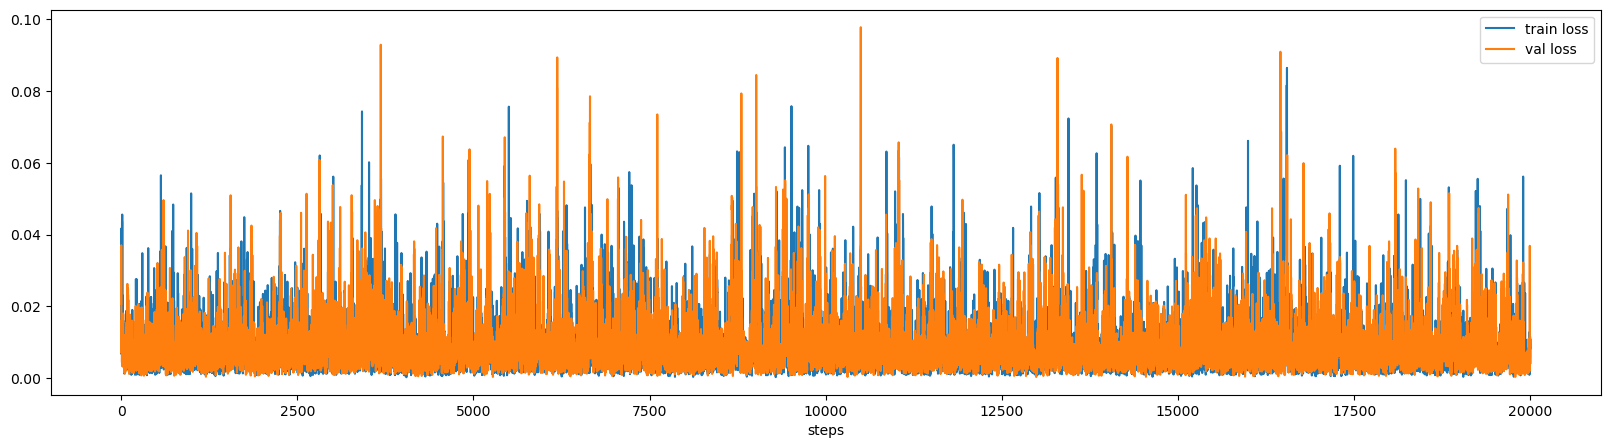

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(train_loss_plot, label='train loss')
plt.plot(val_loss_plot, label='val loss')
plt.xlabel('steps')
plt.legend()
plt.savefig(dir_path / 'loss.png')
plt.show()

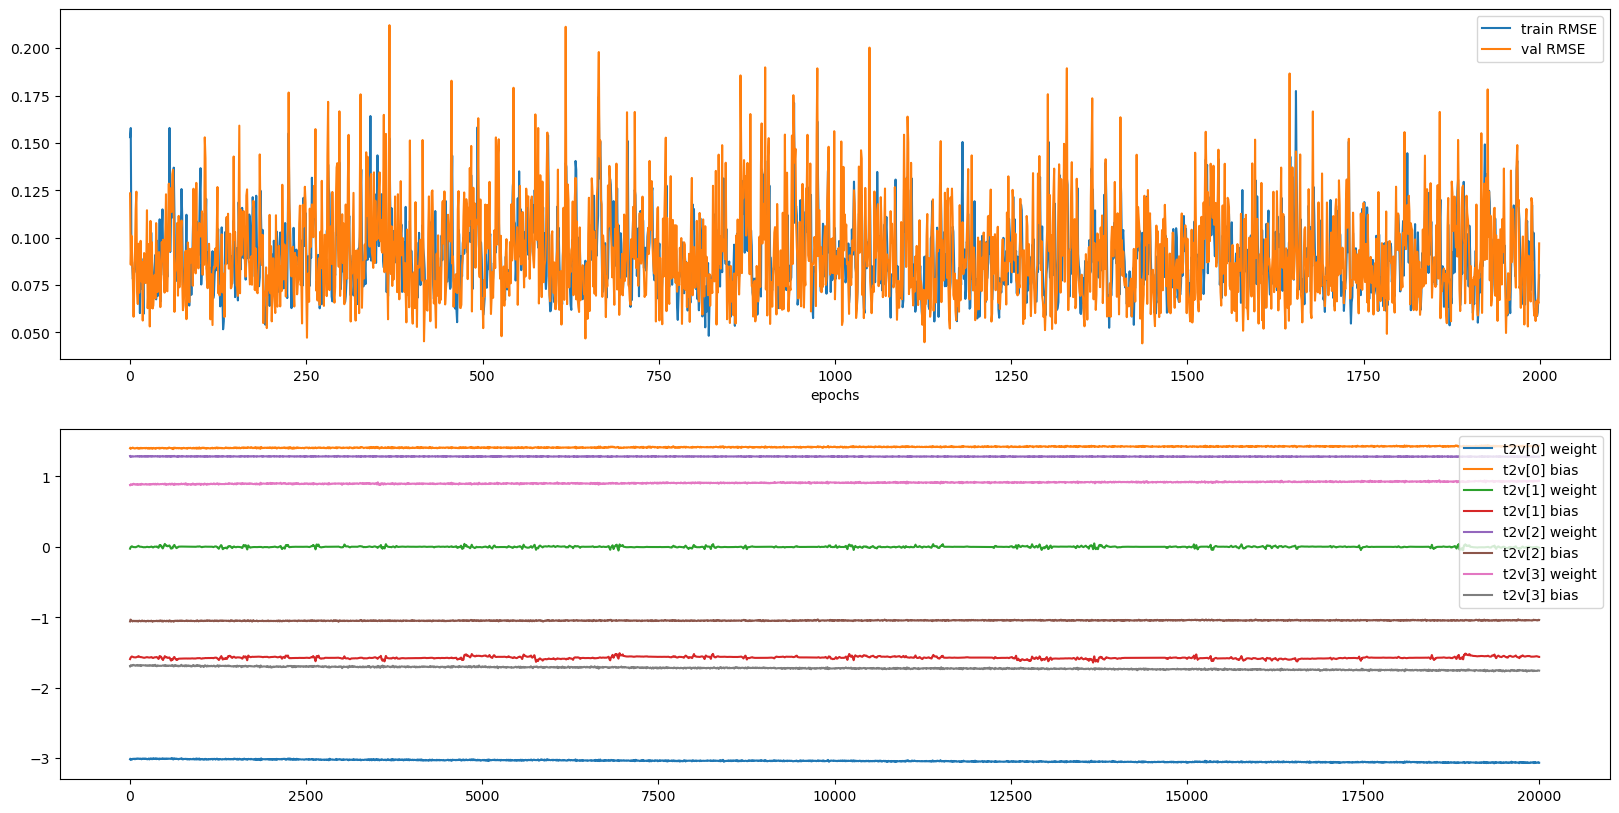

In [29]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(train_RMSE_plot, label='train RMSE')
plt.plot(val_RMSE_plot, label='val RMSE')
plt.xlabel('epochs')
plt.legend()
plt.subplot(2, 1, 2)
t2v_weights = np.array(t2v_weights)
t2v_bias = np.array(t2v_bias)
for i in range(t2v_weights.shape[1]):
    plt.plot(t2v_weights[:, i], label=f't2v[{i}] weight')
    plt.plot(t2v_bias[:, i], label=f't2v[{i}] bias')
plt.legend()
plt.savefig(dir_path / 'RMSE.png')
plt.show()

In [30]:
t2v_weights.shape

(20000, 4, 1)

In [31]:
import yaml
with open(dir_path / 'config.yaml', 'w') as f:
    yaml.dump({
        'experiment': experiment,
        'model': model.__class__.__name__,
        'time_embed_dim': model.time2vec.embedding_dim,
        'feature_dim': model.key_dim - model.time2vec.embedding_dim,
        'hidden_dim': model.graph_attention_generator.hidden_dim,
        'out_dim': model.prediction.out_features,
        'dropout': model.graph_attention_generator.dropout.p,
        'negative_slope': model.graph_attention_generator.leaky_relu.negative_slope,
        'include_linear': model.time2vec.include_linear,
        'epochs': epochs,
        'lowest_loss': lowest_loss,
        'f': sinusoid_data.f,
        'fs': sinusoid_data.fs,
    }, f)

In [32]:
tau_query = torch.linspace(0, 1, 1000)
tau_query.shape

torch.Size([1000])

In [33]:
node = sinusoid_dataset.node.unsqueeze(0).repeat(1000, 1)
node_t = sinusoid_dataset.node_t.unsqueeze(0).repeat(1000, 1)

In [34]:
# load model
model.load_state_dict(torch.load(dir_path / f"best_GAT_model_{experiment}.mdl"))
model = model.to(device)
model.eval()
with torch.no_grad():
    y_hat, total_attention = model(node, node_t, tau_query, device=device)
    y_hat = y_hat.cpu().numpy()
    total_attention = total_attention.cpu().numpy()

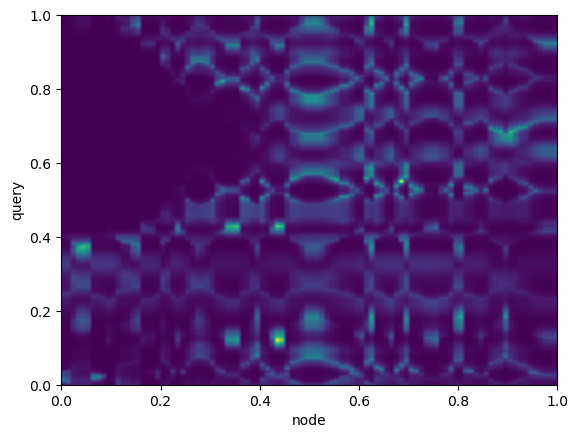

In [35]:
fig, ax = plt.subplots()
plt.imshow(total_attention, extent=[0, 1, 0, 1], cmap='viridis')
ax.axis('tight')
plt.xlabel("node")
plt.ylabel("query")
plt.savefig(dir_path / 'generation_attention.png')
plt.show()

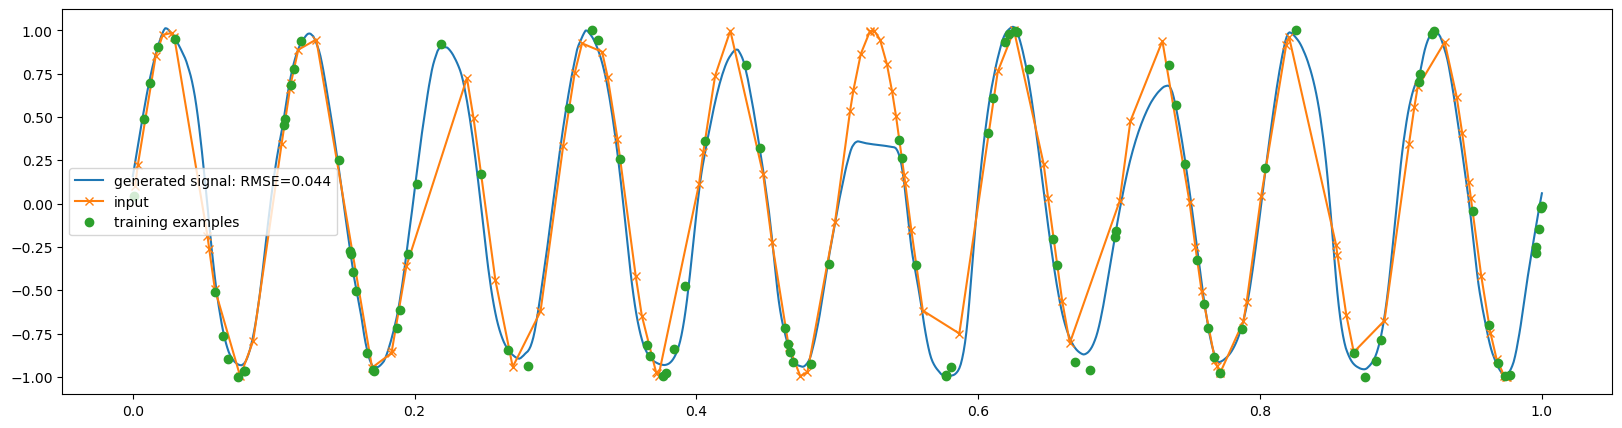

In [36]:
plt.figure(figsize=(20, 5))
plt.plot(tau_query, y_hat, label=f'generated signal: RMSE={min(val_RMSE_plot):.3f}')
# plt.plot(sinusoid_data.t/sinusoid_data.t.max(), sinusoid_data.x, label='ground truth signal')
plt.plot(sinusoid_dataset.node_t, sinusoid_dataset.node, '-x', label=f'input')
plt.plot(sinusoid_dataset.target_t, sinusoid_dataset.target, 'o', label=f'training examples')
plt.legend()
plt.savefig(dir_path / 'generation.png')
plt.show()

In [37]:
output = model.time2vec(tau_query.unsqueeze(-1).to(device))
output = output.detach().cpu().numpy()
output.shape

(1000, 4)

In [38]:
model.time2vec.scale.weight

Parameter containing:
tensor([[-3.0582],
        [-0.0100],
        [ 1.2823],
        [ 0.9376]], device='cuda:0', requires_grad=True)

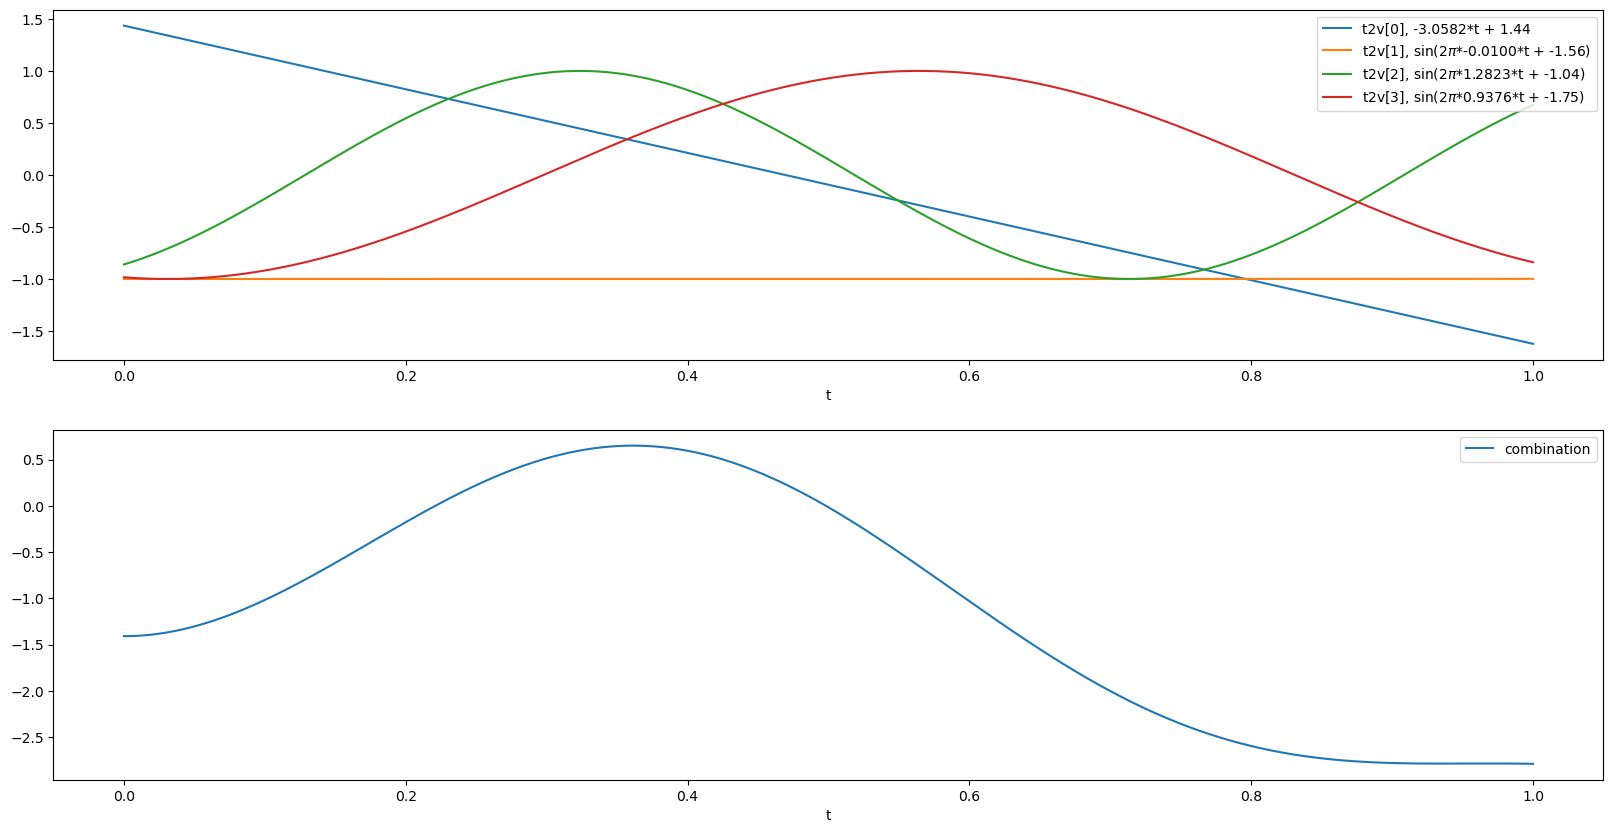

In [39]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
combination = np.sum(output, axis=-1)
pi = r"$\pi$"
for i in range(output.shape[-1]):
    if i == 0 and model.time2vec.include_linear:
        plt.plot(np.linspace(0, 1, output.shape[0]), output[:, i], label=f't2v[{i}], {model.time2vec.scale.weight[i].item():.4f}*t + {model.time2vec.scale.bias[i].item():.2f}')
    else:
        plt.plot(np.linspace(0, 1, output.shape[0]), output[:, i], label=f't2v[{i}], sin(2{pi}*{model.time2vec.scale.weight[i].item():.4f}*t + {model.time2vec.scale.bias[i].item():.2f})')
plt.legend()
plt.xlabel('t')
plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, 1, output.shape[0]), combination, label='combination')
plt.legend()
plt.xlabel('t')
plt.savefig(dir_path / 't2v.png')
plt.show()